# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml
import sys

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [25]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_measurement import *

In [11]:
def f_get_run_summary(df_summary,Lx,Lt,equil,top_dir,run_label):
    '''
    Combine results from multiple runs
    
    '''
    fldr_list=glob.glob(top_dir+'run_Lx-%s_Lt-%s*'%(Lx,Lt))
    # print(fldr_list)

    print("Equil",equil)

    for run_fldr in fldr_list: 
    #     print(run_fldr)
        # Read config file from folder
        input_dict=f_read_config(run_fldr+'/config.yaml')

        # Extract info from HMC output 
        flist=glob.glob(run_fldr+'/HSDM?.out')
        if len(flist)<1:    
            print("Not file HSDM*.out in %s"%(run_fldr))
            continue


        # sort output file list sequentially
        flist=[file_name.split('HSDM')[0]+'HSDM%s.out'%(i+1) for i,file_name in enumerate(flist)]

        ## Sum results from successive runs
        for idx,fname in enumerate(flist):
            print(fname)

            try : 
                df_a=f_parse_grid_data(fname)
    #             display(a)
            except Exception as e:
                print(e,fname)
                continue

            if idx==0:
                df=df_a.copy()
            else : 
                df=f_merge_df_successive_runs(df,df_a)

        if equil>=df.shape[0]:
            print("Skipping %s, not enough configs"%(fname))
            continue

        key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
        
        if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
            key+='_Ls-%s'%(input_dict['dwf_Ls'])

        key+='_'+run_label
        
        count=1
        while(key in data_dict.keys()): # If duplicate key, add suffix
            print("Key exists",key,fname)
            count+=1
            key=key+'_%s'%(count)
            if count>10: break

        data_dict[key]=df

        # Get summary data
        dict2={}
        for key in ['beta','mf','Lx','Lt']:   dict2[key]=input_dict[key]
        if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
            dict2['Ls']=input_dict['dwf_Ls']
        dict2=f_get_summary_data(df,input_dict['Lx'],dict2,equil)

        dict2['run_type']=run_label
        df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
    return df_summary,data_dict


## Main run

In [12]:
Lx='*'
Lt='*'
data_dict={}
df_summary=pd.DataFrame([])

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/'
df_summary,data_dict = f_get_run_summary(df_summary,16,8,50,top_dir,'cold-start')

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/'
df_summary,data_dict = f_get_run_summary(df_summary,16,8,50,top_dir,'hot-start')

# Drop rows with no values
df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)
display(df_summary)


Equil 50
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/run_Lx-16_Lt-8_Ls-16_beta-10.0_mf-0.1/HSDM1.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/run_Lx-16_Lt-8_Ls-16_beta-10.2_mf-0.1/HSDM1.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/run_Lx-16_Lt-8_Ls-16_beta-10.4_mf-0.1/HSDM1.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/run_Lx-16_Lt-8_Ls-16_beta-10.6_mf-0.1/HSDM1.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/run_Lx-16_Lt-8_Ls-16_beta-10.6_mf-0.1/HSDM2.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/run_Lx-16_Lt-8_Ls-16_beta-10.8_mf-0.1/HSDM1.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_4_cold_start/run_Lx-16_Lt-8_Ls-16_bet

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/HSDM1.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/HSDM2.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/HSDM3.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/HSDM4.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/HSDM5.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.6_mf-0.1/HSDM1.out
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.6_mf-0.1/HS

,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf,run_type
0,10.0,0.1,16,8,16,0.413056(67),0.00222(24),1.41(26)e-07,0.00372(16),0.0134(14),1.34(23)e-07,141.286(21),80.864198,122,cold-start
1,10.0,0.1,16,8,16,0.413527(62),0.00189(31),2.5(1.0)e-07,0.00354(16),0.0129(22),2.7(1.4)e-07,141.403(22),78.125000,120,hot-start
2,10.2,0.1,16,8,16,0.441942(94),0.00439(50),1.53(36)e-07,0.00358(16),0.0120(14),1.64(45)e-07,142.903(22),84.472050,121,cold-start
3,10.2,0.1,16,8,16,0.442378(89),0.00384(45),1.55(31)e-07,0.00337(15),0.0108(12),1.44(29)e-07,142.857(26),88.607595,118,hot-start
4,10.4,0.1,16,8,16,0.51581(12),0.00741(99),2.03(51)e-07,0.00370(15),0.0130(14),1.59(35)e-07,132.814(76),92.571429,135,cold-start
5,10.4,0.1,16,8,16,0.51334(24),0.0303(20),9.3(1.3)e-08,0.00340(15),0.0118(17),2.16(91)e-07,134.351(93),92.215569,127,hot-start
6,10.6,0.1,16,8,16,0.547091(34),0.00209(12),1.48(15)e-07,0.00450(11),0.0226(14),1.63(24)e-07,113.75(14),92.697769,453,cold-start
7,10.6,0.1,16,8,16,0.547152(63),0.00250(25),1.50(30)e-07,0.00442(17),0.0191(22),1.79(46)e-07,114.31(24),96.391753,154,hot-start
8,10.8,0.1,16,8,16,0.564308(30),0.001816(98),1.45(16)e-07,0.00689(17),0.0557(36),1.79(26)e-07,101.190(98),93.371212,488,cold-start
9,10.8,0.1,16,8,16,0.564422(44),0.00130(14),1.69(32)e-07,0.00598(26),0.0458(66),2.53(89)e-07,99.51(10),94.500000,160,hot-start


In [13]:
# df_sliced=df_summary[(df_summary.Lt==8)&(df_summary.mf==0.1)]
# df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))|((df_summary.Lt==12)&(df_summary.mf==0.067))].copy()
df_sliced=df_summary.copy()
print(df_sliced.shape)
display(df_sliced)


(38, 15)


,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,polyakov,sus_poly,kurt_poly,traj_time,accept,num_conf,run_type
0,10.0,0.1,16,8,16,0.413056(67),0.00222(24),1.41(26)e-07,0.00372(16),0.0134(14),1.34(23)e-07,141.286(21),80.864198,122,cold-start
1,10.0,0.1,16,8,16,0.413527(62),0.00189(31),2.5(1.0)e-07,0.00354(16),0.0129(22),2.7(1.4)e-07,141.403(22),78.125000,120,hot-start
2,10.2,0.1,16,8,16,0.441942(94),0.00439(50),1.53(36)e-07,0.00358(16),0.0120(14),1.64(45)e-07,142.903(22),84.472050,121,cold-start
3,10.2,0.1,16,8,16,0.442378(89),0.00384(45),1.55(31)e-07,0.00337(15),0.0108(12),1.44(29)e-07,142.857(26),88.607595,118,hot-start
4,10.4,0.1,16,8,16,0.51581(12),0.00741(99),2.03(51)e-07,0.00370(15),0.0130(14),1.59(35)e-07,132.814(76),92.571429,135,cold-start
5,10.4,0.1,16,8,16,0.51334(24),0.0303(20),9.3(1.3)e-08,0.00340(15),0.0118(17),2.16(91)e-07,134.351(93),92.215569,127,hot-start
6,10.6,0.1,16,8,16,0.547091(34),0.00209(12),1.48(15)e-07,0.00450(11),0.0226(14),1.63(24)e-07,113.75(14),92.697769,453,cold-start
7,10.6,0.1,16,8,16,0.547152(63),0.00250(25),1.50(30)e-07,0.00442(17),0.0191(22),1.79(46)e-07,114.31(24),96.391753,154,hot-start
8,10.8,0.1,16,8,16,0.564308(30),0.001816(98),1.45(16)e-07,0.00689(17),0.0557(36),1.79(26)e-07,101.190(98),93.371212,488,cold-start
9,10.8,0.1,16,8,16,0.564422(44),0.00130(14),1.69(32)e-07,0.00598(26),0.0458(66),2.53(89)e-07,99.51(10),94.500000,160,hot-start


<IPython.core.display.Javascript object>


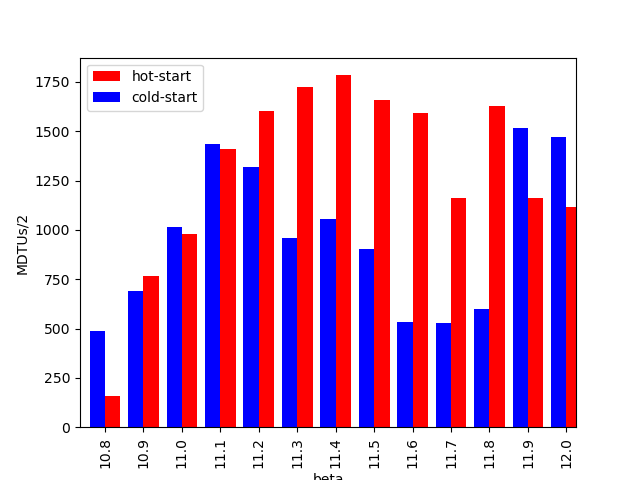

In [22]:
## Plot number of configs
df=df_sliced[(df_sliced.beta>10.7)&(df_sliced.beta<12.1)][['beta','run_type','num_conf']]
df.set_index('beta',inplace=True)

# display(df)

width=0.4 

plt.figure()

label='hot-start'
df[df.run_type==label].num_conf.plot(kind='bar', width=width, color='red', position=0, label=label)

label='cold-start'
df[df.run_type==label].num_conf.plot(kind='bar', width=width, color='blue', position=1, label=label)

plt.legend(loc='best')

plt.ylabel("MDTUs/2")
plt.savefig('fig_output/num_confs.pdf')

In [15]:
# data_dict.keys()

In [16]:
# df_sliced[df_sliced.beta>11.6]

## Summary plots

In [17]:
mf_list   = np.sort(np.unique(df_sliced.mf.values))
beta_list = np.sort(np.unique(df_sliced.beta.values))
# Lt_list = np.sort(np.unique(df_sliced.Lt.values))

## Combining Lx and Lt into a label 
L_list=np.unique([str(i)+'_'+str(j)+'_'+str(k) for i,j,k in zip(df_sliced.Lx.values, df_sliced.Lt.values, df_sliced.run_type.values)])
mf_list,beta_list,L_list

(array([0.1]),
 array([10. , 10.2, 10.4, 10.6, 10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4,
        11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.5, 13. ]),
 array(['16_8_cold-start', '16_8_hot-start'], dtype='<U15'))

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


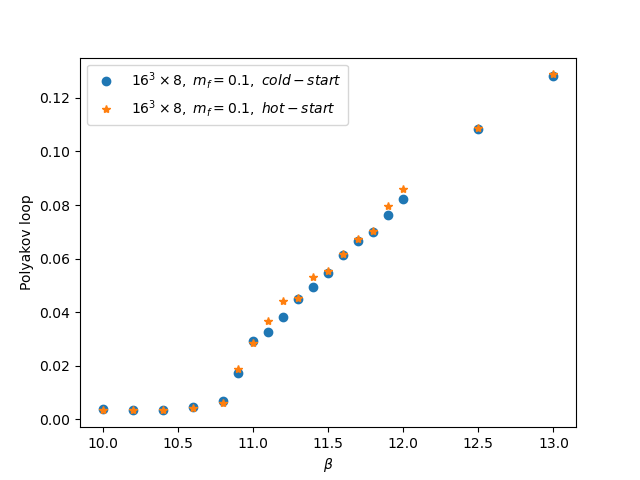

In [18]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt,run_type=int(l.split('_')[0]),int(l.split('_')[1]),l.split('_')[2]
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)&(df_sliced.run_type==run_type)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s,\ %s$'%(l.split('_')[0],l.split('_')[1],mf,run_type)

        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.polyakov.values
    #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        plt.plot(x,gv.mean(y),linestyle='',label=label,marker=marker)
        
plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.5))
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('fig_output/Ploop_vs_beta.pdf')

### Plaquette vs beta

<IPython.core.display.Javascript object>


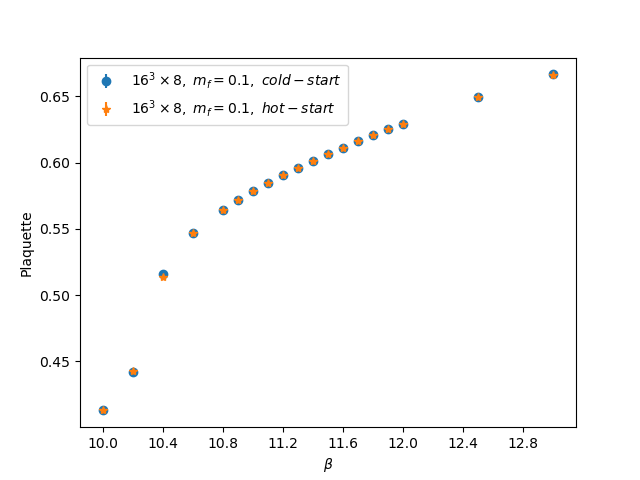

In [19]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt,run_type=int(l.split('_')[0]),int(l.split('_')[1]),l.split('_')[2]
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)&(df_sliced.run_type==run_type)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s,\ %s$'%(l.split('_')[0],l.split('_')[1],mf,run_type)


        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.plaq.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Plaquette',rotation='vertical')
plt.show()
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('fig_output/Plaq_vs_beta.pdf')

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [20]:
# plt.figure()

# for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
#     lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
#     df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
#     for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):
#         label='beta=%s_l=%s'%(beta,l)
#         df1=df[df.beta==beta].sort_values(by=['mf'])
#     #     display(df1)

#     #     if df1.shape[0]>1:
#         x=df1.mf.values
#         y=df1.polyakov.values
#     #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Polyakov loop',rotation='vertical')
# # plt.savefig('Ploop_vs_mf.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


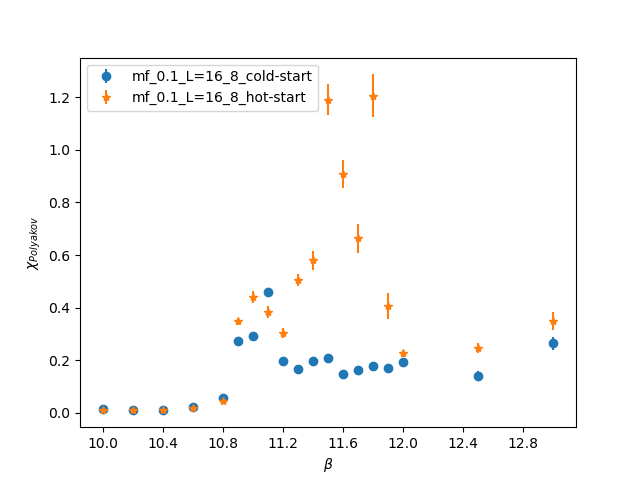

In [21]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt,run_type=int(l.split('_')[0]),int(l.split('_')[1]),l.split('_')[2]
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)&(df_sliced.run_type==run_type)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.sus_poly.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
plt.savefig('fig_output/chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


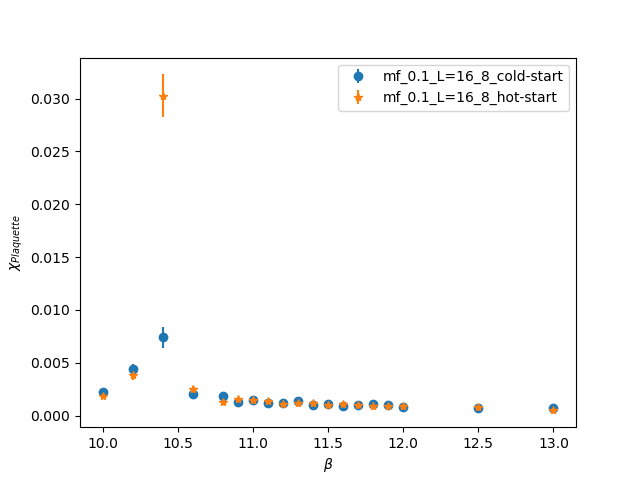

In [22]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt,run_type=int(l.split('_')[0]),int(l.split('_')[1]),l.split('_')[2]
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)&(df_sliced.run_type==run_type)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.sus_plaq.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
plt.savefig('fig_output/chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


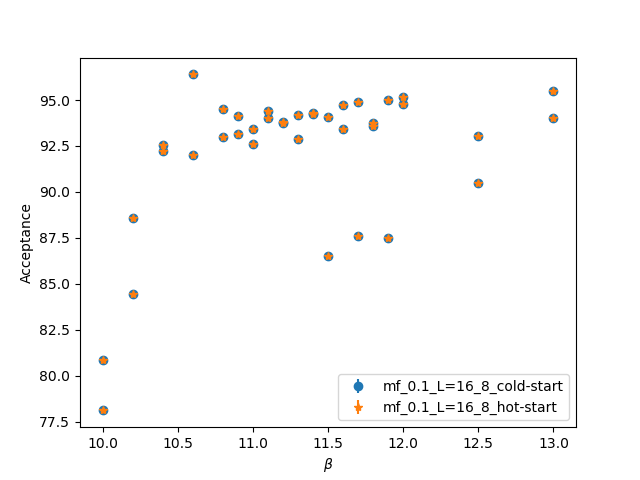

Text(0, 0.5, 'Acceptance')

In [23]:
# Plot acceptance rate 

# plt.figure()

# for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

#     label='beta_%s'%(beta)
#     df1=df_sliced[df_sliced.beta==beta].sort_values(by=['mf'])
# #     display(df1)
    
# #     if df1.shape[0]>1:
#     x=df1.mf.values
#     y=df1.accept.values
# #     print(x,y)
#     plt.plot(x,y,linestyle='',label=label,marker=marker)
# #     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Acceptance',rotation='vertical')
# # plt.savefig('Acceptance_vs_mf.pdf')


plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.accept.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_beta.pdf')


## Individual plots

In [24]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.7_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.8_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-12.5_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-13.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.6_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.5_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.1_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.3_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.2_mf-0.1_Lx-16_Lt-8_L

['beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start']


<IPython.core.display.Javascript object>


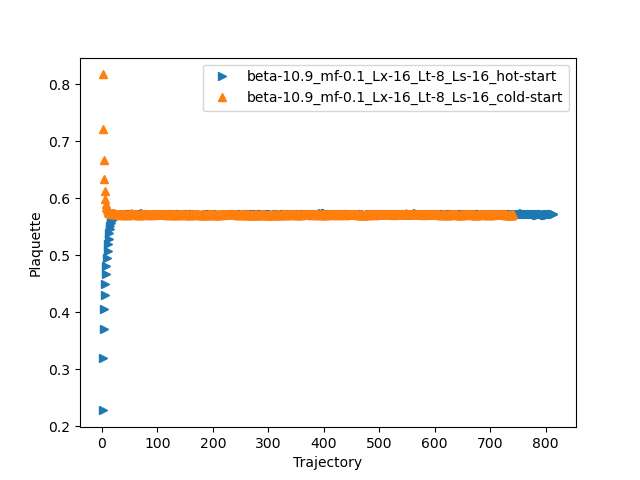

beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


<IPython.core.display.Javascript object>


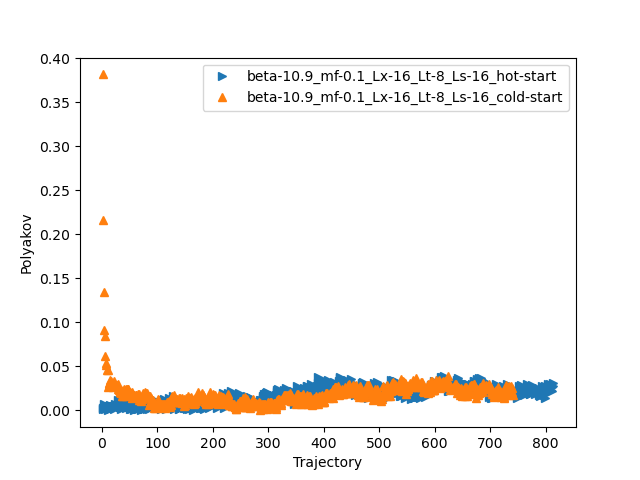

beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


In [42]:

def f_plot_specific_runs(data_dict,column,keys_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
# beta_list=[9.0,10.0,10.2,10.4,10.5,10.6,10.8]
beta_list=[10.9][:]
mf_list=[0.1]
## Gather dict keys with given beta and mf values
Ls=16
Lt=8
keys_list1=['beta-%s_mf-%s_Lx-16_Lt-%s_Ls-%s_hot-start'%(b,m,Lt,Ls) for m in mf_list for b in beta_list]
keys_list2=['beta-%s_mf-%s_Lx-16_Lt-%s_Ls-%s_cold-start'%(b,m,Lt,Ls) for m in mf_list for b in beta_list]

keys_list=keys_list1+keys_list2
print(keys_list)


f_plot_specific_runs(data_dict,'Plaquette',keys_list)
plt.savefig('fig_output/Plaq_details.pdf')

# f_plot_specific_runs(data_dict,'Traj_time',keys_list)

f_plot_specific_runs(data_dict,'Polyakov',keys_list)
plt.savefig('fig_output/Polyakov_details.pdf')


In [44]:
data_dict['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start'].keys()

Index(['Plaquette', 'iter', 'Polyakov', 'Traj_time', 'Accept'], dtype='object')

<IPython.core.display.Javascript object>


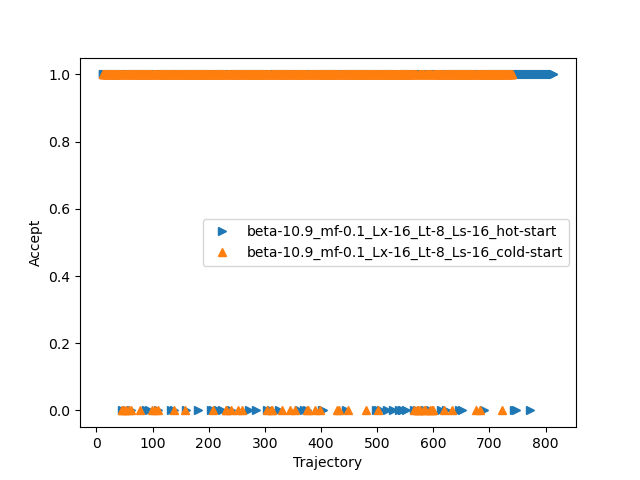

beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


In [45]:
f_plot_specific_runs(data_dict,'Accept',keys_list)


<IPython.core.display.Javascript object>


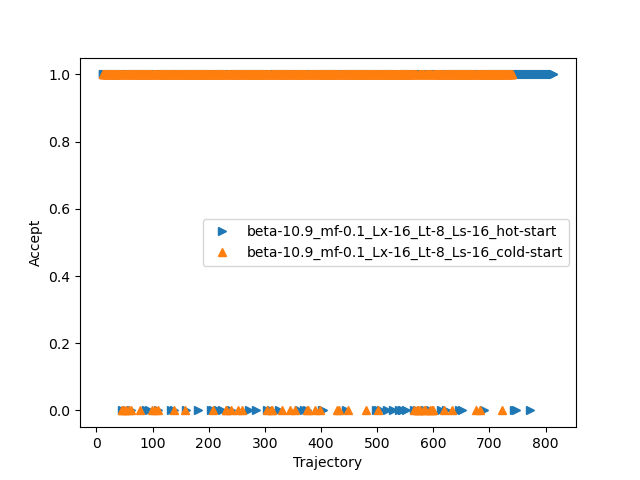

beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


In [46]:
f_plot_specific_runs(data_dict,'Accept',keys_list)


### Plot Polyakov loop

In [47]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


In [48]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.7_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.8_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-12.5_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-13.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.6_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.5_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.1_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-11.3_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start', 'beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.2_mf-0.1_Lx-16_Lt-8_L

In [49]:
data_dict['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start']

,Plaquette,iter,Polyakov,Traj_time,Accept
0,0.799540,1.0,0.343463-0.001219j,80.448097,NaN
1,0.694446,2.0,0.175152+0.003129j,94.869598,NaN
2,0.631471,3.0,0.098847-0.000524j,95.374001,NaN
3,0.591034,4.0,0.057916+0.004860j,95.558296,NaN
4,0.563872,5.0,0.042579+0.001160j,97.441101,NaN
...,...,...,...,...,...
167,0.412961,168.0,0.002976+0.000878j,140.927994,1.0
168,0.413654,169.0,0.001447+0.000450j,141.201996,1.0
169,0.414353,170.0,0.002187-0.003817j,141.785995,1.0
170,0.414576,171.0,0.003028-0.003857j,141.375000,1.0


<IPython.core.display.Javascript object>


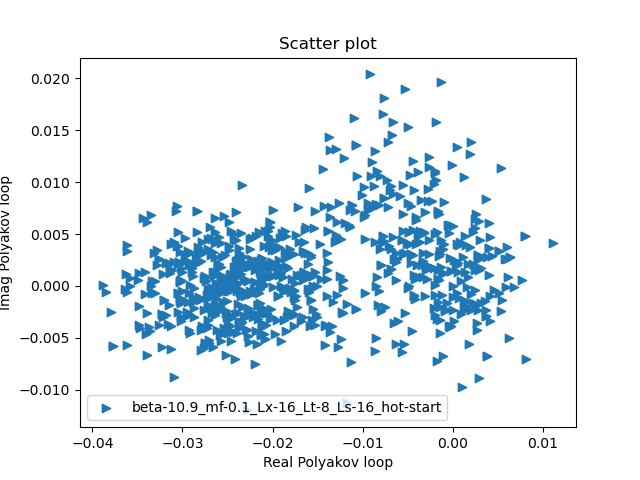

beta-10.9_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start


In [50]:
keys_list=['beta-%s_mf-%s_Lx-16_Lt-8_Ls-16_hot-start'%(b,m) for m in mf_list for b in beta_list]

fig=plt.figure()

for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):
    df=data_dict[i]
    label=i
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

<IPython.core.display.Javascript object>


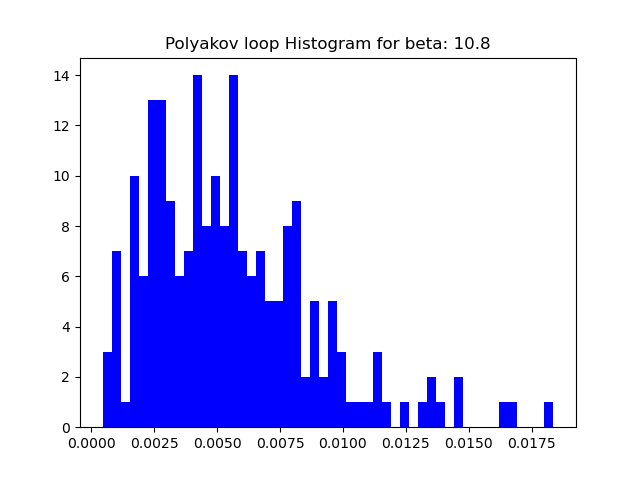

Text(0.5, 1.0, 'Polyakov loop Histogram for beta: 10.8')

In [51]:
# Histogram
beta=10.8
mf=0.1
key='beta-%s_mf-%s_Lx-16_Lt-8_Ls-16_hot-start'%(beta,mf)

df=data_dict[key]

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
# plt.savefig('ploop_histogram.pdf')